<img src='img/header.png' align='right' width='100%'/>

<font color="#138D75">**Marine Earth Observation Training**</font> <br>

**License:** MIT <br>
**Authors:** Marie Smith (CSIR)

**Note:** This notebook was modified from [this example](https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/applications/ocean-case-studies/-/blob/main/Case_studies/Water_quality/Algal_blooms/Algal_blooms_baltic_2023.ipynb?ref_type=heads) by Ben Loveday (EUMETSAT/Innoflair UG) and Hayley Evers-King (EUMETSAT)

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

This notebook has the following prerequisites:
- **<a href="https://dunia.esa.int/sandbox" target="_blank">A DUNIA account</a>** to access the DUNIA Sandbox Jupyter lab


</div>
<hr>

# Investigating phytoplankton blooms off the coast of Namibia

### Data used

| Dataset | EUMETSAT collection ID | EUMETSAT collection<br>description | Product Identifier |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution | EO:EUM:DAT:0407 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC" target="_blank">Description</a> | /eodata/Sentinel-3/OLCI/OL_2_WFR___/ | 
### Learning outcomes

At the end of this notebook you will know how to ;

* access Sentinel-3 OLCI data on the DUNIA Sandbox using the EODAG tool
* visualise and appropriately flag derived chlorophyll-a data from these products
* compare and understand differences between data derived with different chlorophyll-a algorithms
* plot the ocean colour phytoplankton type product to contextualise bloom events
* understand the limitations of using chlorophyll-a concentrations for detecting blooms in coastal waters
* assess the latest research on algorithm development and bloom quantification in the Benguela


### Outline
Whilst production by algae is an essential component of marine foodwebs and biogeochemical cycling, extreme blooms [[1]](#ref1) can also pose risks to environmental and human health. Blooms can affect fish stocks, aquaculture, bathing water quality and tourism, as well as causing rashes, respiratory, and gastrointestinal issues for those exposed. 

Satellite ocean colour can provide operational views of water quality, with the Sentinel-3 mission particularly well suited to observing eutrophication and algal blooms such as those occurring in the Benguela [[2]](#ref2). However retrieving accurate geophysical information in these situations is not trivial, and products such a chlorophyll-a derived from a variety of algorithms, can be more/less suitable.  

This notebook shows how to access ocean colour data on the DUNIA Sandbox platform, and to visualise derived products of algal biomass (from both standard and regionally developed [[2]](#ref2) algorithms) and phytoplankton types [[3]](#ref3)  

#### References

1. <a id='ref1'><a href="https://aslopubs.onlinelibrary.wiley.com/doi/10.4319/lo.1997.42.5_part_2.1132" target="blank">Smayda, T. J. (1997). What is a bloom? A commentary. Limnology and Oceanography, 42(5part2), 1132-1136.</a>
2. <a id='ref2'><a href="https://doi.org/10.1016/j.rse.2018.06.002" target="_blank">Smith, M. E., Lain, L. R., & Bernard, S. (2018). An optimized chlorophyll a switching algorithm for MERIS and OLCI in phytoplankton-dominated waters. Remote Sensing of Environment, 215, 217-227.</a>
3. <a id='ref3'><a href="https://doi.org/10.3389/fmars.2020.00061" target="blank">Smith, M. E., & Bernard, S. (2020). Satellite ocean color based harmful algal bloom indicators for aquaculture decision support in the Southern Benguela. Frontiers in Marine Science, 7, 61.</a>


<div class="alert alert-info" role="alert">

## <a id='TOCTOP'></a>Contents

</div>

 1. [Step 1: Setting up our analysis](#section1)
 1. [Step 2: Accessing the data on CreoDIAS](#section2)
 1. [Step 3: Comparing standard level-2 chlorophyll estimates](#section3)
 1. [Step 4: Conclusions](#section4)

<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting up our analysis
[Back to top](#TOCTOP)

</div>

In this section we will set up all the parameters we need to run our notebook.

We will begin by importing all of the libraries that we need to run this notebook. 

In [1]:
import os                              # a library that allows us access to basic operating system commands
import glob                            # a library that helps us search for files
import eumartools as EMT                     # a EUMETSAT library that support working with Sentinel-3 products
#import eumdac                          # a tool that helps us download via the eumetsat/data-store
import datetime                        # a library that allows us to work with dates and times
import shutil                          # a library that allows us access to basic operating system commands like copy
import xarray as xr                    # a library that helps us work efficiently with multi-dimensional arrays
import matplotlib                      # a library the provides plotting capability
import matplotlib.pyplot as plt        # a library the provides plotting capability
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy                         # a library that supports mapping and projection
import cartopy.crs as ccrs             # a library that supports mapping and projection
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np                     # a library that lets us work with arrays; we import this with a new name "np"
from pathlib import Path               # a library that helps construct system path objects
import getpass                         # a library to help us enter passwords
import warnings                        # a library that supports managing warning messages
import fnmatch
from dateutil.relativedelta import relativedelta
from datetime import datetime
from openpyxl import load_workbook
import cmocean

#import copernicusmarine                # a library to help us access CMEMS data
from eodag import EODataAccessGateway, setup_logging
import pft_utilities as PFT

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})


On the first attempt to run this notebook you might find that a <code>ModuleNotFoundError</code> appears in a red box below. This just means that you need to install the missing module(s). To do this, you use the <code>!pip install module-name</code>. We recommend you remove the # from the next line and run it once, after which all the modules should be installed. Remember to re-run the import cell above in order to make sure that everything is imported correctly.

In [2]:
#!pip install copernicusmarine

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Accessing the data on CreoDIAS
[Back to top](#TOCTOP)

</div>

The beauty of the DUNIA Sandbox is that it is a cloud-based research environment with co-located data and computing services. We are going to use the Earth Observation Data Access Gateway (EODAG) python
library to search for a specific Sentinel 3 OLCI file within CreoDIAS.

Below is the code snippet that will get the filename of the Sentinel 3 OLCI full resolution Level 2 water product that you will be using; it shows data for the 9th of July 2025, collected at approximately 08:41am UCT. To save some time we have already pre-selected a specific file ID <code>id="S3B_OL_2_WFR____20250709T084132_20250709T084432_20250710T144720_0179_108_292_3240_MAR_O_NT_003"</code> to use. It is also possible to use a region of interest (bounding box) and time period to search for multiple files, however, we will leave that example for another notebook.   

If you would like, change the ID in the code below to any of the following to access the bloom data from a different date:

<code>S3B_OL_2_WFR____20240112T084447_20240112T084747_20240113T152922_0179_088_235_3240_MAR_O_NT_003</code>
<code>S3A_OL_2_WFR____20240407T085357_20240407T085657_20240408T151908_0179_111_064_3240_MAR_O_NT_003</code>
<code>S3A_OL_2_WFR____20240404T083429_20240404T083729_20240405T151851_0179_111_021_3420_MAR_O_NT_003</code>

You can explore and try to find even more images to plot using the EODAG tool yourself. You will find the tool on the left hand side of the screen. You can draw a box around your region of interest, select a Provider (e.g. cop_dataspace, creodias), a Product Type <code>S3_OLCI_L2WFR</code>, and a start and end date to search over. Then click the blue "preview results" button and the available dates and preview images will show up on the right. You can then select an image from the results, and press the "generate code for this product" button on the bottom right - this will generate the python code needed to actually find/access/read the specific data file within the sandbox datasets. 

<img src='img/EODAG_search_results.png' align='left' width='100%'/>

In [3]:
setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
search_results = dag.search(
    provider="cop_dataspace",
    productType="S3_OLCI_L2WFR", 
    id="S3B_OL_2_WFR____20250709T084132_20250709T084432_20250710T144720_0179_108_292_3240_MAR_O_NT_003",
)
search_results

SearchResult([EOProduct(id=S3B_OL_2_WFR____20250709T084132_20250709T084432_20250710T144720_0179_108_292_3240_MAR_O_NT_003, provider=cop_dataspace)])

In this section of the notebook we will select and acquire some Sentinel-3 OLCI data that is relevant to our region of interest (ROI) along the coast of Namibia off Walvis Bay. Lets begin by defining the bounds of this region, converting them into a well known text (WKT) format polygon that describes the list of the corners of a box. We will also define all of the reflectance bands and product bands that we will need in order to derive additional data products, mask and plot the data. 

In [4]:
# defining our bounding box (W, E, S, N)
#ROI_L2 = [13.62, 14.677, -23.56, -21.187] # Walvis Bay, Erongo Region 
ROI_L2 = [14.1, 14.6, -23.1, -21.9] # Walvis Bay, zoom
#ROI_L2 = [14.216309, 15.358887, -27.293689, -24.986058] # Luderitz Region

roi_L2 = [[ROI_L2[0], ROI_L2[2]], [ROI_L2[1], ROI_L2[2]], [ROI_L2[1], ROI_L2[3]], [ROI_L2[0], ROI_L2[3]], [ROI_L2[0], ROI_L2[2]]]

# components
all_components = ["Oa03_reflectance.nc","Oa04_reflectance.nc", "Oa05_reflectance.nc", "Oa06_reflectance.nc",
                  "Oa07_reflectance.nc","Oa08_reflectance.nc", "Oa10_reflectance.nc", "Oa11_reflectance.nc", 
                  "Oa12_reflectance.nc", "chl_nn.nc", "chl_oc4me.nc", "geo_coordinates.nc", "wqsf.nc"]


<div class="alert alert-warning" role="alert">

## <a id='section99'></a>Defining functions
[Back to top](#TOCTOP)

</div>

#### Defining a quick function to supporting plotting

Before we move on to our analysis, we are going to define a quick function for use later on. We define functions when we have some code that we want to use repeatedly later on. In this section we define a quick functions that we will use to aid plotting. You don't need to worry about how this function works, and so it is hidden by default. You can click on the "+1 cell hidden" box below if you want to see it.

In [5]:
def embellish_plot(m):
    """Quick function to embellish plots with gridlines and labels

    Args:
        m (axis): the axis to plot into
    Returns:
        None
    """
    # Embellish with gridlines
    m.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='k', facecolor='#546d51', linewidth=0.5), zorder=500)
    g1 = m.gridlines(draw_labels = True, linestyle='--', linewidth=0.5, zorder=1000)
    g1.top_labels = g1.right_labels = False
    g1.xlabel_style = g1.ylabel_style = {'color': '0.5'}



<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Comparing standard level-2 chlorophyll estimates
[Back to top](#TOCTOP)

</div>

Level-2 products for ocean colour contain the atmospherically corrected reflectance measurements of the ocean surface at various wavelengths (i.e. the 'colour'). From these estimates of geophysical parameters such as the chlorophyll-a concentration can be derived. Numerous approaches have been tested for this in accurate ways across different water types. There are variations of the classic empirical approach which empirically relates the ratio of blue:green light reflected to the chlorophyll-a concentrations. There are also more complex approaches using modern techniques such as neural networks/AI/machine learning to derive chlorophyll-a and other parameters. 

In the standard OLCI product, there is a chlorophyll-a concentration provided using an example of each of these methods - the OC4ME (empirical), and CHL_NN (using a network trained on a range of in situ measurements). Typically the former is suitable for open ocean waters where phytoplankton are the dominant source of variability, and the other where there are more different sources of variability such as river run off, resuspension of sediments etc. Let's take a look and see how these algorithms perform over our coastal area.

First, lets open our level-2 files as an xarray Dataset, and also identify the auxillary flag related information we need.

In [6]:
the_file = search_results[0]
product_id = the_file.properties["productIdentifier"]
SAFE_directory = os.path.join("/home/eoafrica" + product_id)
SAFE_directory


'/home/eoafrica/eodata/Sentinel-3/OLCI/OL_2_WFR___/2025/07/09/S3B_OL_2_WFR____20250709T084132_20250709T084432_20250710T144720_0179_108_292_3240_MAR_O_NT_003.SEN3'

In [7]:
date_str = os.path.basename(SAFE_directory).split('_')[7]
dt = datetime.strptime(date_str, "%Y%m%dT%H%M%S")

file_paths = [os.path.join(SAFE_directory, f) for f in all_components]

l2_files = [xr.open_dataset(fp) for fp in file_paths]
ds_l2 = xr.merge(l2_files)

In [8]:
ds_l2

<xarray.Dataset> Size: 2GB
Dimensions:               (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/26)
    Oa03_reflectance      (rows, columns) float32 80MB ...
    Oa03_reflectance_unc  (rows, columns) float32 80MB ...
    Oa04_reflectance      (rows, columns) float32 80MB ...
    Oa04_reflectance_unc  (rows, columns) float32 80MB ...
    Oa05_reflectance      (rows, columns) float32 80MB ...
    Oa05_reflectance_unc  (rows, columns) float32 80MB ...
    ...                    ...
    CHL_OC4ME             (rows, columns) float32 80MB ...
    CHL_OC4ME_unc         (rows, columns) float32 80MB ...
    altitude              (rows, columns) float32 80MB ...
    latitude              (rows, columns) float64 159MB ...
    longitude             (rows, columns) float64 159MB ...
    WQSF                  (rows, columns) uint64 159MB ...
Attributes: (12/17)
    absolute_orbit_number:  37524
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2025-07-10T14:47:20Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r5 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.06
    start_time:             2025-07-09T08:41:31.854045Z
    stop_time:              2025-07-09T08:44:31.777912Z
    title:                  OLCI Level 2 WATER Product, Reflectance Oa03 Data...

In [9]:
# get flag file
for l2_file in file_paths:
    if "wqsf" in l2_file:
        flag_file = l2_file

# subset image
ex = {}
ey = {}
mask = {}

ex["l2"], ey["l2"], mask["l2"] = EMT.subset_image(ds_l2["longitude"], ds_l2["latitude"], [i[0] for i in roi_L2], [i[1] for i in roi_L2])


Next, we will create some masks to appropriate flag our chlorophyll-a estimates. We'll use the flags that <a href="https://user.eumetsat.int/s3/eup-strapi-media/Recommendations_for_Sentinel_3_OLCI_Ocean_Colour_product_validations_in_comparison_with_in_situ_measurements_Matchup_Protocols_V8_B_e6c62ce677.pdf" target="_blank">EUMETSAT recommend</a> to create our masks, beginning with a mask for the OC4ME algorithm;

In [10]:
# creating masks for CHL_OC4ME: BAC recommended flags
OC4ME_mask = EMT.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'OC4ME_FAIL'])
OC4ME_mask = OC4ME_mask.astype(float)
OC4ME_mask[OC4ME_mask == 1.0] = np.nan
OC4ME_mask[np.isfinite(OC4ME_mask)] = 1.0


# creating masks for CHL_OC4ME: BAC recommended flags
OC4_mask = EMT.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS','ANNOT_ABSO_D'])
OC4_mask = OC4_mask.astype(float)
OC4_mask[OC4_mask == 1.0] = np.nan
OC4_mask[np.isfinite(OC4_mask)] = 1.0

# creating masks for CHL_NN: NN recommended flags
NN_mask = EMT.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'OCNN_FAIL'])
NN_mask = NN_mask.astype(float)
NN_mask[NN_mask == 1.0] = np.nan
NN_mask[np.isfinite(NN_mask)] = 1.0

# creating masks for Medium Sun Glint
MEDGlint_mask = EMT.flag_mask(flag_file, 'WQSF', ['MEGLINT'])
MEDGlint_mask = MEDGlint_mask.astype(float)
MEDGlint_mask[MEDGlint_mask == 1.0] = np.nan
MEDGlint_mask[np.isfinite(MEDGlint_mask)] = 1.0

# creating masks for the red-NIR algorithm, G2B
G2B_mask = EMT.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE','AC_FAIL'])
G2B_mask = G2B_mask.astype(float)
G2B_mask[G2B_mask == 1.0] = np.nan
G2B_mask[np.isfinite(G2B_mask)] = 1.0

Lets now apply the masks to our chlorophyll products, ensuring that only high quality data remains.

In [11]:
CHL_OC4ME = ds_l2["CHL_OC4ME"] * OC4ME_mask
CHL_NN = ds_l2["CHL_NN"] * NN_mask

a,b = CHL_OC4ME.shape 

Next up we use an external function that we imported earlier to derive the regional Chl-a product (chl_blend) and the regional phytoplankton type product (all_phyto)

In [12]:
all_phyto, chl_blend = PFT.get_chlblend_phytotype(ds_l2,OC4_mask,G2B_mask,MEDGlint_mask)

In [13]:
## this section just sets up the map projection and defines the coastline and river datasets:
coord = ccrs.PlateCarree()

land_hires = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                          edgecolor='k', facecolor='0.75')
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines','10m', 
                                      facecolor='none', edgecolor='blue')

# make a color map of fixed colors for Phyto type map
cmap = colors.ListedColormap([(0.93,0.93,0.93),(0.93,0.5,0.93),(0.5,0.91,0.91),(0.8,0.7,0.1),(0.2,0.2,1),(0,0.8,0),(0.6,0,0)])
bounds=[0,0.5,1.5,2.5,3.5,4.5,5.5,6.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# make a color map of fixed colors for Chl-a
jetcmap = cm.get_cmap("nipy_spectral", 10) #generate a jet map with 10 values 
jet_vals = jetcmap(np.arange(10)) #extract those values as an array 
jet_vals[9] = [0.4, 0, 0, 1] #change the last value 
newcmap = mpl.colors.LinearSegmentedColormap.from_list("newjet", jet_vals)

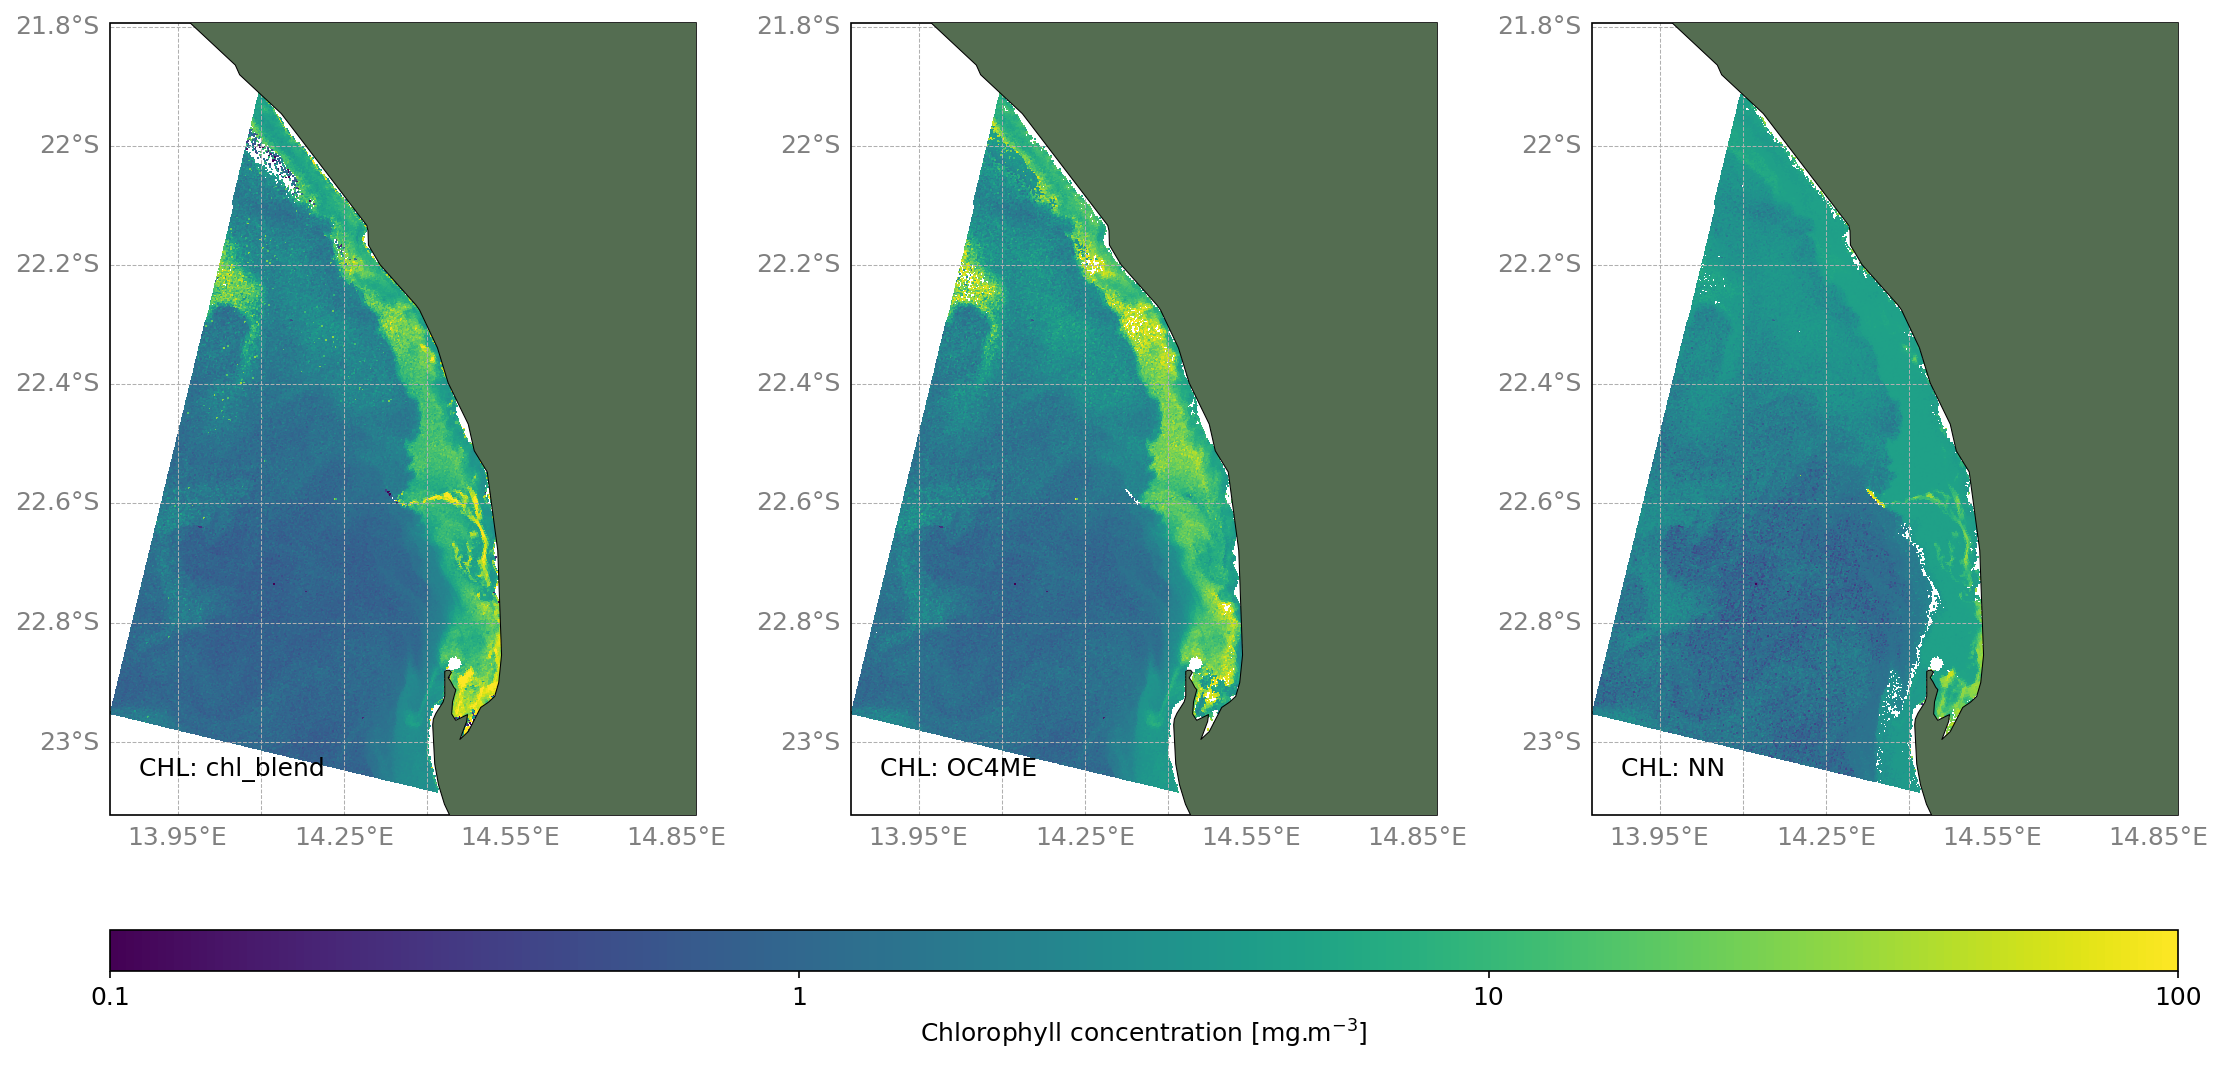

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8), dpi=150, subplot_kw={"projection": ccrs.Mercator()})

for m, chl, label in zip(axs, [np.log10(chl_blend), CHL_OC4ME, CHL_NN], ['CHL: chl_blend', 'CHL: OC4ME', 'CHL: NN']):
    
    p1 = m.pcolormesh(ds_l2["longitude"][min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
                      ds_l2["latitude"][min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
                      chl[min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
                      vmin=-1, vmax=2, transform=ccrs.PlateCarree())
    embellish_plot(m)
    m.annotate(label, (0.05, 0.05), xycoords="axes fraction", zorder=1000, color='k')

plt.tight_layout()

cbar = fig.colorbar(p1, ax=axs[:], location='bottom', pad=0.1, aspect=50)
ticks = [-1, 0, 1, 2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')
plt.show()

We can see that there are significant differences between the algorithms. The chl_blend and OC4ME show significantly higher chlorophyll-a estimates than the CHL_NN, particularly over the areas with potential algal blooms. These results can be complicated by other things image suchs thin clouds, aerosols, dust blowing off the land, and sediments in the coastal regions. Understanding the methods behind these algorithms, we can begin to understand that they may not be the most suitable approaches. 

The OC4ME algorithm may generally be suitable for waters where the biomass (Chl-a) is <30 mg/m3, but the assumptions on which this algorithm are based tend to break down at higher concentrations. OC4ME may also produce erroneously high Chl-a results if suspended sediments or dust clouds are present. 

The chl_blend algorithm uses a similar approach to OC4ME over low biomass conditions, but switches over to a red-NIR band-ratio algorithm over high biomass, which produces more reliable results under these conditions. 

For the CHL_NN, the method is limited by the training set, which was focused on a broad range of water types, and not explicitly high biomass blooms. It may be able to cope better with additional suspended sediments in the water, and may replicate spatial patterns of biomass, but might not accurately reproduce the extent of the phytoplankton biomass. 

<img src='img/OCIMS_chl_hab.png' align='left' width='85%'/>

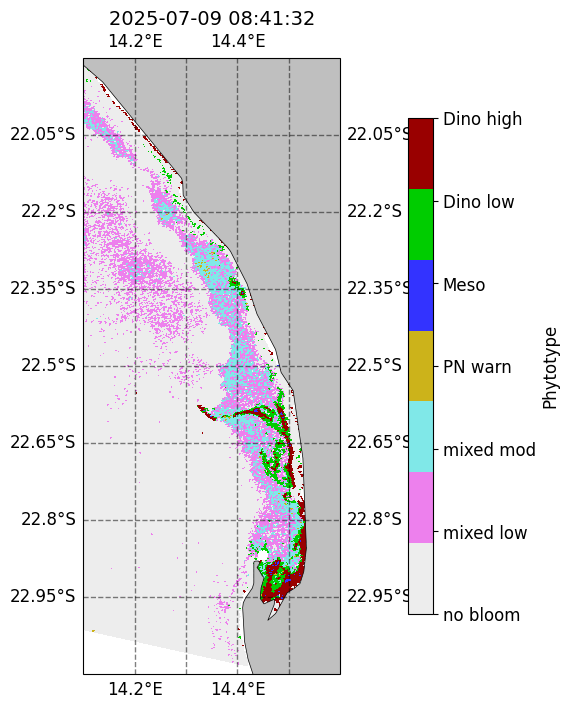

In [15]:
## this is the longer version of a plot
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection=coord)
CS = ax.pcolor(ds_l2["longitude"][min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
               ds_l2["latitude"][min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
               all_phyto[min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
               vmin=0, vmax=6, cmap=cmap)
ax.set_title(dt,fontsize=14)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="k", alpha=0.5, linestyle="--")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True
ax.add_feature(land_hires, linewidth=0.5) 
ax.add_feature(rivers, linewidth=0.5,linestyle=':')

## uncomment one of the below lines, if you want the zoomed-out or zoomed-in image:
ax.set_extent(ROI_L2, crs=coord);                      #<--- zoomed-out
#ax.set_extent([14.25,14.55,-23.1,-22.5], crs=coord)   #<--- zoomed-in

cbar = fig.colorbar(CS, ax=ax, fraction=0.04, pad=0.11,label='Phytotype')
ticks = [0,1,2,3,4,5,6]
cbar.set_ticks(ticks)
cbar.set_ticklabels(['no bloom','mixed low','mixed mod','PN warn','Meso','Dino low','Dino high'])

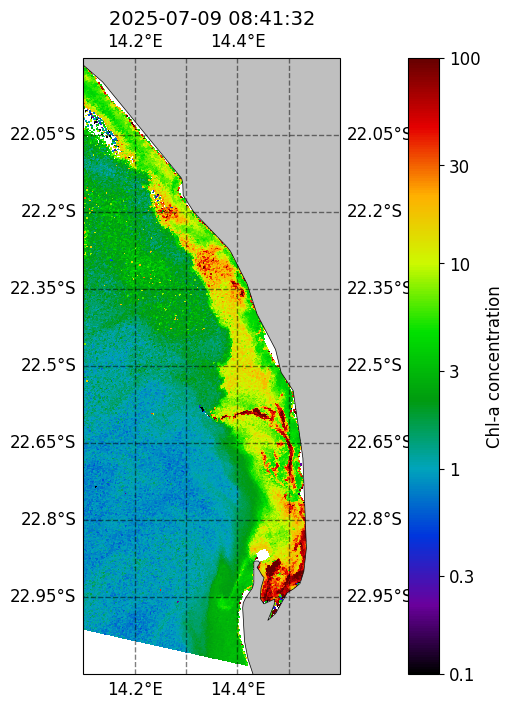

In [16]:
## this is the longer version of a plot
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection=coord)
CS = ax.pcolormesh(ds_l2["longitude"][min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
               ds_l2["latitude"][min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
               np.ma.masked_invalid(np.log10(chl_blend))[min(ey["l2"]):max(ey["l2"]), min(ex["l2"]):max(ex["l2"])],
               vmin=np.log10(0.1), vmax=np.log10(100), cmap=newcmap)
ax.set_title(dt,fontsize=14)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="k", alpha=0.5, linestyle="--")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True
ax.add_feature(land_hires, linewidth=0.5) 
ax.add_feature(rivers, linewidth=0.5,linestyle=':')

## uncomment one of the below lines, if you want the zoomed-out or zoomed-in image:
ax.set_extent(ROI_L2, crs=coord);                      #<--- zoomed-out
#ax.set_extent([14.25,14.55,-23.1,-22.5], crs=coord)   #<--- zoomed-in

ticks = [np.log10(0.1),np.log10(0.3), np.log10(1),np.log10(3),np.log10(10),np.log10(30),np.log10(100)]
cbar = fig.colorbar(CS, ax=ax, pad=0.11,label='Chl-a concentration',ticks=ticks)
cbar.set_ticklabels(['0.1','0.3','1','3','10','30','100']) 



In [17]:
ds_l2.close()

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Conclusions
[Back to top](#TOCTOP)

</div>

In this notebook we have seen that satellite data is capable of providing a detailed view of coastal bloom events in the Benguela region. Modern sensors such as the OLCI sensors aboard the Sentinel-3 satellites can be exploited, thanks to their unique spectral bands, to develop specific algorithms for detection of blooms. Longer time series of ocean colour data are being developed to support the assessment of the role of blooms in eutrophication trends in regions such as the Benguela. As the time series of OLCI data lengthens, and new opportunities from hyperspectral missions are realised, further opportunities will arise to expand this work.

### Suggested next steps

To further develop your skills and knowledge, and expand the application of this notebook you could try:
* Changing the file id to look at the bloom conditions on a different date
* Changing the region of interest to look at a different part of the coast
